# CNN for Porous Media

Use a Convolutional Neural Network (CNN) to classify images of porous media. The dataset used is synthetically generated using the code provided in the notebook. 


In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [5]:
def generate_image(size=(128, 128), gap=False, closed_channel=False):
    image = Image.fromarray(np.random.randint(0, 256, size, dtype=np.uint8))
    draw = ImageDraw.Draw(image)
    if gap:
        if np.random.rand() > 0.5:
            y = np.random.randint(size[1] // 4, 3 * size[1] // 4)
            draw.line((0, y, size[0], y), fill=0, width=3)
        else:
            x = np.random.randint(size[0] // 4, 3 * size[0] // 4)
            draw.line((x, 0, x, size[1]), fill=0, width=3)
    if closed_channel:
        start_point = (np.random.randint(20, size[0]-20), np.random.randint(20, size[1]-20))
        end_point = (start_point[0] + np.random.randint(10, 30), start_point[1] + np.random.randint(10, 30))
        draw.line([start_point, end_point], fill=255, width=np.random.randint(1, 4))
    return np.array(image)

def save_images(num_images, base_dir):
    for subdir in ['train', 'validation', 'test']:
        path = os.path.join(base_dir, subdir)
        for label in ['0', '1']:
            os.makedirs(os.path.join(path, label), exist_ok=True)
    for i in range(num_images):
        gap = np.random.rand() > 0.5
        closed_channel = np.random.rand() > 0.5
        img = generate_image(gap=gap, closed_channel=closed_channel)
        label = '1' if (gap or closed_channel) else '0'
        if i < num_images * 0.7:
            subdir = 'train'
        elif i < num_images * 0.85:
            subdir = 'validation'
        else:
            subdir = 'test'
        filename = f"{i}.png"
        path = os.path.join(base_dir, subdir, label, filename)
        Image.fromarray(img).save(path)

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(base_dir):
    datagen = ImageDataGenerator(rescale=1./255)
    train_generator = datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary'
    )
    validation_generator = datagen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary'
    )
    test_generator = datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False
    )
    model = build_model()
    model.fit(train_generator, epochs=10, validation_data=validation_generator)
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy: {test_acc*100:.2f}%")

    return model, test_generator

In [6]:
# Usage
base_dir = 'synthetic_dataset'
save_images(300, base_dir)
model, test_generator = train_and_evaluate_model(base_dir)

Found 210 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Epoch 1/10
11/11 [==============================] - 4s 257ms/step - loss: 0.6881 - accuracy: 0.6952 - val_loss: 0.6524 - val_accuracy: 0.6889
Epoch 2/10
11/11 [==============================] - 3s 300ms/step - loss: 0.5941 - accuracy: 0.7190 - val_loss: 0.6199 - val_accuracy: 0.6889
Epoch 3/10
11/11 [==============================] - 4s 349ms/step - loss: 0.6105 - accuracy: 0.7190 - val_loss: 0.6182 - val_accuracy: 0.6889
Epoch 4/10
11/11 [==============================] - 5s 489ms/step - loss: 0.6106 - accuracy: 0.7190 - val_loss: 0.6146 - val_accuracy: 0.6889
Epoch 5/10
11/11 [==============================] - 4s 366ms/step - loss: 0.5865 - accuracy: 0.7190 - val_loss: 0.6299 - val_accuracy: 0.6889
Epoch 6/10
11/11 [==============================] - 4s 323ms/step - loss: 0.5907 - accuracy: 0.7190 - val_loss: 0.5757 - val_accuracy: 0.6889
Epoch 7/10
11/11 [=========

1/1 [==============================] - 0s 240ms/step


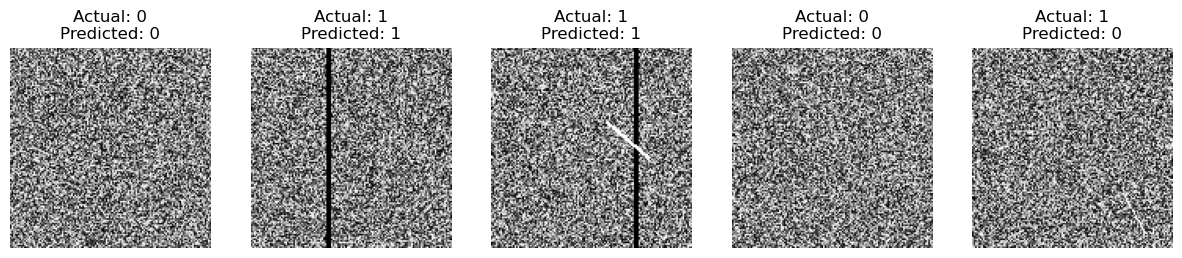

In [7]:
# Load all test data
all_test_images, all_test_labels = test_generator.next()
all_predictions = model.predict(all_test_images).flatten()
all_predictions = np.round(all_predictions)

# Select 5 random samples to display
indices = np.random.choice(range(len(all_test_labels)), 5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(indices):
    ax = axes[i]
    ax.imshow(all_test_images[idx].reshape(128, 128), cmap='gray')
    ax.set_title(f"Actual: {int(all_test_labels[idx])}\nPredicted: {int(all_predictions[idx])}")
    ax.axis('off')
plt.show()